## Random Forest Regressor

In [109]:
#libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#get_ipython().run_line_magic('matplolib', 'inline')

from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, r2_score, mean_squared_error

import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

from scipy.stats import boxcox
from sklearn import metrics
from timeit import default_timer as timer
from dateutil.parser import parse
from datetime import datetime
from scipy import stats
import warnings

warnings.filterwarnings('ignore')

from IPython.display import display, Markdown

pd.set_option('display.max_rows', 999)
pd.set_option('display.max_columns', 999)
pd.set_option('display.width', 800)
pd.set_option('display.max_colwidth', None)

pd.options.display.float_format = '{:.3f}'.format

plt.style.use('seaborn-whitegrid')
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = '17'

In [110]:
#Funções auxiliares

def sum_billion(x):    
    return round(((x.sum())/1000000000.0),2)

def sum_million(x):    
    return round(((x.sum())/1000000.0),2)

def sum_thousand(x):    
    return round(((x.sum())/1000.0),2)

def media_agregada(x):    

    return round(((x.sum())/12.0),0)

def ignore_nans(a,b):
    index = ~a.isnull() & ~b.isnull()
    return a[index], b[index]

In [111]:
grupo = 'Adesão - Grande - Cooperativa Médica' 

grupo_csv = "ade_g_coopmed.csv"

path = r'D:\TCC\TCC\codigos\preparacao_dados\analise_agrupadas\adesao\porte_grande\adesao_grande_cooperativa_medica' + '\\' + grupo_csv

ans = pd.read_csv(grupo_csv, sep=';', decimal= ',', encoding='mbcs')

ans.head()

,ano,cd_ops,trimestre,receita,despesa,benef,modalidade,port_ops,contratacao
0,2018,303976,2018Q1,29314392.257,23298026.978,27209,Cooperativa Médica,Grande,Adesao
1,2018,342084,2018Q1,100884002.783,71227129.017,50901,Cooperativa Médica,Grande,Adesao
2,2018,348295,2018Q2,4388045.611,4255788.457,6692,Cooperativa Médica,Grande,Adesao
3,2018,348295,2018Q3,4596013.001,4967336.847,6736,Cooperativa Médica,Grande,Adesao
4,2018,348295,2018Q4,4842097.207,3878879.670,7581,Cooperativa Médica,Grande,Adesao


In [112]:
ans_agrup = ans.groupby(['ano','trimestre'], as_index=False).agg({  'receita':lambda x: sum_billion(x),
                                                                    'despesa':lambda x: sum_billion(x),
                                                                    'benef': 'sum',
                                                                    'cd_ops':lambda x: x.nunique()})

ans_agrup['pct_despesa'] = ans_agrup.apply(lambda x: (x['despesa']/x['receita'])*100 , axis = 1).round(2)

ans_agrup.columns = ['ano','trimestre','receita','despesa','benef','n_ops','pct_despesa']

ans_agrup = ans_agrup[['trimestre','receita','despesa','benef','n_ops','pct_despesa']]

ans_agrup = ans_agrup[(ans_agrup.trimestre > '2017Q4') & (ans_agrup.trimestre < '2022Q1')]

ans_agrup[['n_ops','benef']] = ans_agrup[['n_ops','benef']].astype('int')

ans_agrup['ano'] = ans_agrup['trimestre'].str[:4]

ans_agrup['ano'] = ans_agrup['ano'].astype('int')

ans_agrup['n_tri'] = ans_agrup['trimestre'].str[-1:]

ans_agrup['n_tri'] = ans_agrup['n_tri'].astype('int')

ans_agrup['trimestre'] = pd.PeriodIndex(ans_agrup['trimestre'], freq="Q")

ans_agrup['n_tri_l1'] = ans_agrup['n_tri'].shift(1)

ans_agrup['n_tri_l2'] = ans_agrup['n_tri'].shift(2)

ans_agrup['log_receita'] = np.log(ans_agrup['receita'])

receita, lam_receita = boxcox(ans_agrup['receita'])

ans_agrup['boxcox_receita'] = receita

ans_agrup.set_index('trimestre', inplace=True)

ans_agrup = ans_agrup.dropna()

ans_agrup.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 14 entries, 2018Q3 to 2021Q4
Freq: Q-DEC
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   receita         14 non-null     float64
 1   despesa         14 non-null     float64
 2   benef           14 non-null     int32  
 3   n_ops           14 non-null     int32  
 4   pct_despesa     14 non-null     float64
 5   ano             14 non-null     int32  
 6   n_tri           14 non-null     int32  
 7   n_tri_l1        14 non-null     float64
 8   n_tri_l2        14 non-null     float64
 9   log_receita     14 non-null     float64
 10  boxcox_receita  14 non-null     float64
dtypes: float64(7), int32(4)
memory usage: 1.1 KB


In [113]:
columns_receita = ['receita','log_receita','boxcox_receita']

ans_agrup

,receita,despesa,benef,n_ops,pct_despesa,ano,n_tri,n_tri_l1,n_tri_l2,log_receita,boxcox_receita
trimestre,,,,,,,,,,,
2018Q3,2.290,1.850,1678692,38,80.790,2018,3,2.000,1.000,0.829,0.962
2018Q4,2.380,1.250,1693379,38,52.520,2018,4,3.000,2.000,0.867,1.014
2019Q1,2.370,1.870,1700602,38,78.900,2019,1,4.000,3.000,0.863,1.008
2019Q2,2.460,1.980,1730500,38,80.490,2019,2,1.000,4.000,0.900,1.059
2019Q3,2.550,1.950,1733529,38,76.470,2019,3,2.000,1.000,0.936,1.108
2019Q4,2.650,2.080,1757501,38,78.490,2019,4,3.000,2.000,0.975,1.162
2020Q1,2.750,2.100,1876410,39,76.360,2020,1,4.000,3.000,1.012,1.215
2020Q2,2.790,1.750,1892513,39,62.720,2020,2,1.000,4.000,1.026,1.235
2020Q3,2.830,2.150,1917215,39,75.970,2020,3,2.000,1.000,1.040,1.256


receita


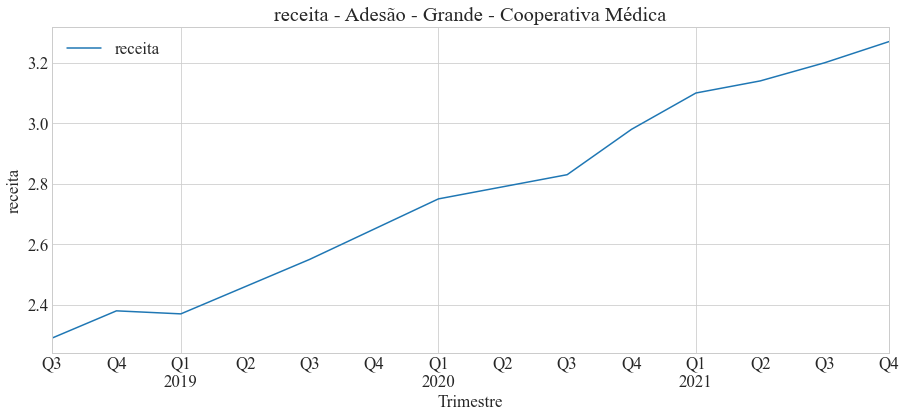

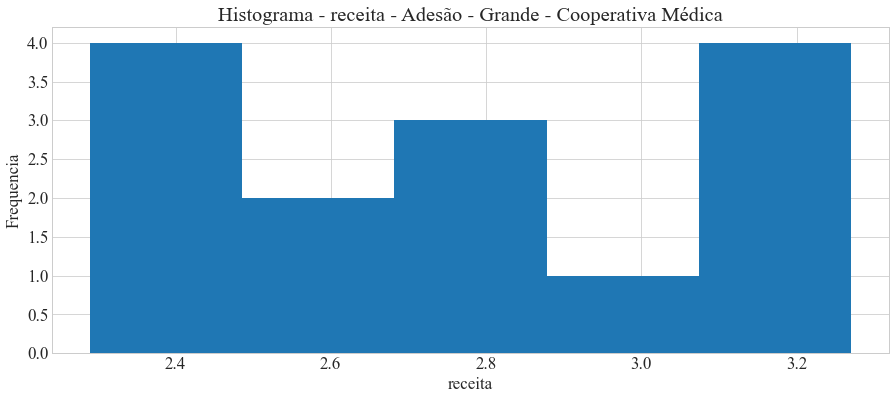

log_receita


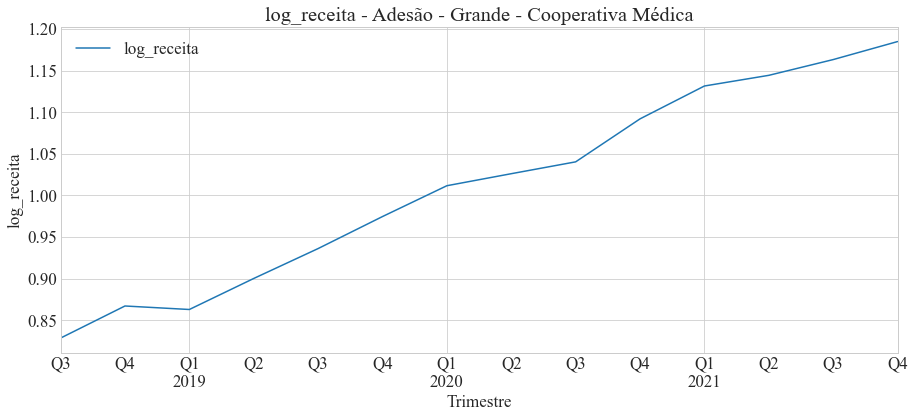

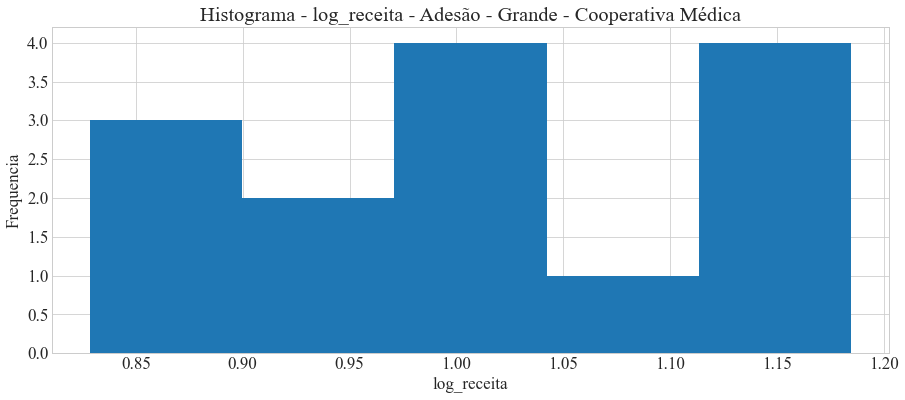

boxcox_receita


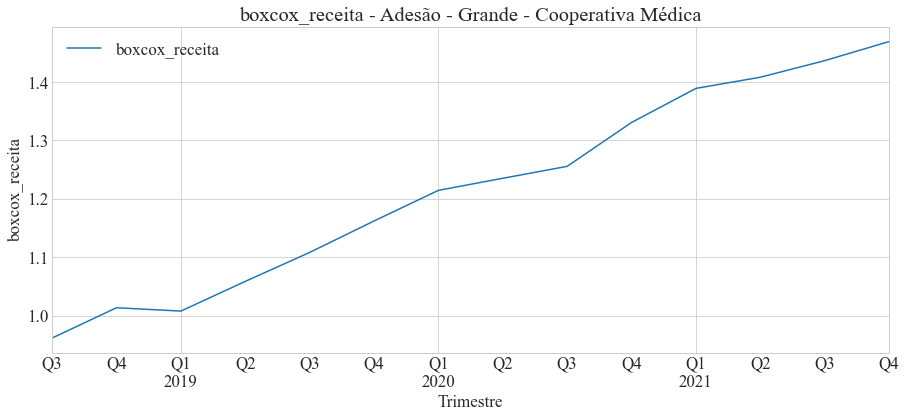

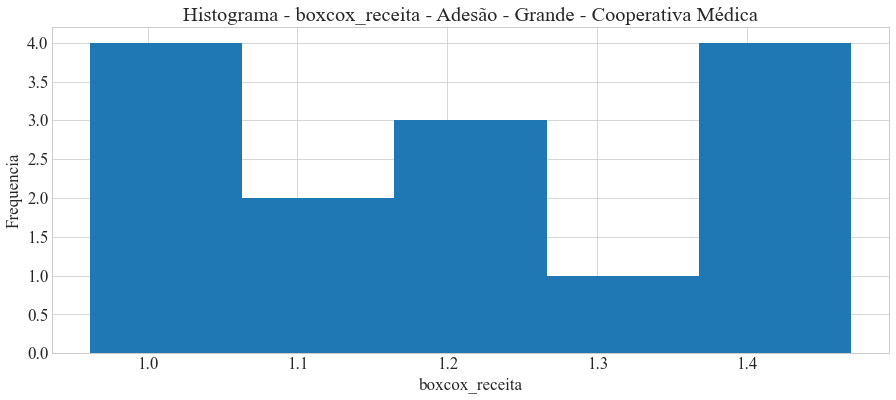

In [114]:
for c in ans_agrup[columns_receita]:
    print(str(c))

    ans_agrup.plot(y = str(c), figsize=(15,6))
    plt.xlabel('Trimestre')
    plt.ylabel(c)
    plt.title(f'{str(c)} - '+ grupo)
    plt.show()

    ans_agrup[str(c)].hist(bins='auto',figsize=(15,6))
    plt.xlabel(str(c))
    plt.ylabel('Frequencia')
    plt.title(f'Histograma - {str(c)} - '+ grupo)
    plt.show()

In [115]:
def timeseries_evaluation_metrics_func(y_true, y_pred):

    def smape(y_true,y_pred):
        num = np.abs(np.subtract(y_true,y_pred))
        den = (np.abs(y_true) + np.abs(y_pred)) / 2
        ratio = num/den
        return ratio.mean()

    print(f'Mean_Squared_Error_(MSE) is : {mean_squared_error(y_true,y_pred)}')

    print(f'Root_Mean_Squared_Error_(RMSE) is : {mean_squared_error(y_true,y_pred, squared=False)}')

    print(f'Mean_Absolute_Error_(MAE) is : {mean_absolute_error(y_true,y_pred)}')

    print(f'Mean_Absolute_Percentage_Error (MAPE) is : {mean_absolute_percentage_error(y_true,y_pred)}')

    print(f'Symmetrical_Mean_Absolute_Percentage_Error (MAPE) is : {smape(y_true,y_pred)}')

    print(f'Coefficient of determination R^2 is : {r2_score(y_true,y_pred)}', end = '\n\n')

    return


def Augmented_Dickey_Fuller_Test_func(series, column_name):

    print(f'Results of Dickey-Fuller Test for column {column_name}')

    dftest = adfuller(series, autolag='AIC')

    dfoutput = pd.Series(dftest[0:4], index=[   'Test Statistic',
                                                'p-value',
                                                'No Lags Used',
                                                'Number of Observartions Used'])
    
    for key, value in dftest[4].items():
        
        dfoutput['Critical Value (%s)' %key] = value

    print(dfoutput)

    if dftest[1] <= 0.05:
        print('Conclusion:====>')
        print('Reject the null hypothesis')
        print('Data is stationary')
    else:
        print('Conclusion:====>')
        print('Fail to reject the null hypothesis')
        print('Data is non-stationary')

In [116]:
#Create X and y object
X = ans_agrup[['ano','n_tri']]
y = ans_agrup['receita']

# Create Train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=3, random_state=1234, shuffle=False)

display(X_train)

display(X_test)

,ano,n_tri
trimestre,,
2018Q3,2018,3
2018Q4,2018,4
2019Q1,2019,1
2019Q2,2019,2
2019Q3,2019,3
2019Q4,2019,4
2020Q1,2020,1
2020Q2,2020,2
2020Q3,2020,3


,ano,n_tri
trimestre,,
2021Q2,2021,2
2021Q3,2021,3
2021Q4,2021,4


In [117]:
my_rf = GridSearchCV( RandomForestRegressor(),
                      {'max_features':[0.5,0.55,0.60,0.65,0.7,0.75,0.8,0.85,0.9,0.95],
                      'n_estimators':[5,10,15,20,30,40,50,100,250,500,750,1000]},
                       scoring='r2', n_jobs=-1)

my_rf.fit(X_train,y_train)

GridSearchCV(estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_features': [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8,
                                          0.85, 0.9, 0.95],
                         'n_estimators': [5, 10, 15, 20, 30, 40, 50, 100, 250,
                                          500, 750, 1000]},
             scoring='r2')

In [118]:
fcst = my_rf.predict(X_test)
timeseries_evaluation_metrics_func(list(y_test),list(fcst))
print(my_rf.best_params_)

Mean_Squared_Error_(MSE) is : 0.09115299999999997
Root_Mean_Squared_Error_(RMSE) is : 0.3019155511065966
Mean_Absolute_Error_(MAE) is : 0.3003333333333333
Mean_Absolute_Percentage_Error (MAPE) is : 0.09375360552731189
Symmetrical_Mean_Absolute_Percentage_Error (MAPE) is : 0.09841712079154862
Coefficient of determination R^2 is : -31.298307086614216

{'max_features': 0.55, 'n_estimators': 10}


In [119]:
fi = pd.DataFrame( {
    'feature': X_train.columns,
    'importance': my_rf.best_estimator_.feature_importances_})

fi.sort_values('importance', ascending=False)    

,feature,importance
0,ano,0.797
1,n_tri,0.203


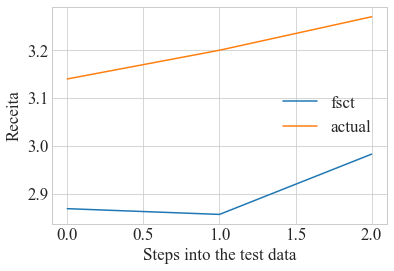

In [120]:
plt.plot(list(fcst))
plt.plot(list(y_test))
plt.legend(['fsct','actual'])
plt.ylabel('Receita')
plt.xlabel('Steps into the test data')
plt.show()

In [121]:
fcst = my_rf.predict(X_train)
print(r2_score(list(y_train),list(fcst)))
print(my_rf.best_params_)

0.9217432895488296
{'max_features': 0.55, 'n_estimators': 10}


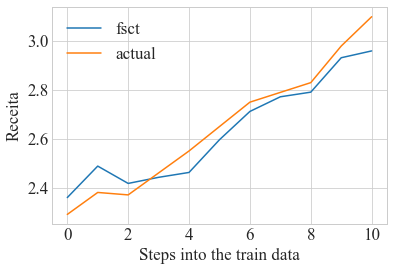

In [122]:
plt.plot(list(fcst))
plt.plot(list(y_train))
plt.legend(['fsct','actual'])
plt.ylabel('Receita')
plt.xlabel('Steps into the train data')
plt.show()

In [123]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits = 3,test_size=2)
rmse_list = []
mape_list = []

for train_index, test_index in tscv.split(X_train):
    X_train_split, X_test_split = X.iloc[train_index], X.iloc[test_index]
    y_train_split, y_test_split = y.iloc[train_index], y.iloc[test_index]

    my_rf.fit(X_train_split,y_train_split)
    fcst = my_rf.predict(X_test_split)
    
    rmse_list.append(np.sqrt(mean_squared_error(list(y_test_split),list(fcst))))
    mape_list.append(mean_absolute_percentage_error(list(y_test_split),list(fcst)))
    
print("RMSE médio: {}".format(np.mean(rmse_list)))
print("MAPE Médio: {}".format(np.mean(mape_list)))

RMSE médio: 0.3120765575656712
MAPE MÉDIO: 0.10523262909956908
